## Plotting the richness dependency with secondary halo parameters
Goal: For each (M,z) bin plot the richness dependency with secondary halo parameters. Include error bars if possible. 

In [1]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
#from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from statsmodels.compat import lzip
#sns.set()
#pd.set_option('display.notebook_repr_html', True)
#pd.set_option('display.precision', 2)
#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 10, 10
from scipy.stats import norm
from scipy import stats

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
## KLLR setup
import sys
sys.path.append('/global/u1/z/zzhang13')

from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

kllr_nbins= 20
kernel_type = 'gaussian'
kernel_width = 0.1

In [5]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

## Halo catalog

In [6]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as f:
    matched_halo_df = pickle.load(f)

In [7]:
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

## Masking

In [8]:
##Mask in mass, redshift bin
mass_min = 2e14; mass_max = 5e14; scale = 0.4922
#a_bins = [1, 0.6712, 0.4922]
mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == scale) 
cur_df = matched_halo_df[mask]

##Split the sample by column
bin_low = 0
bin_high = 50
column_name = 'Acc_Rate_1*Tdyn'
x_var = cur_df[column_name]
percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
cur_df_low = cur_df[mask]
cur_df_high = cur_df[~mask]

## Multilinear Regression

In [9]:
### Use KLLR
lm = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), \
                                                              bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

dy_kllr = lm.residuals(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), bins=kllr_nbins, nBootstrap = 1,
                          fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)


## Low
lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df_low.M200c), np.log10(cur_df_low.Ngal_R200c.values), \
                                                              bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

dy_kllr_low = lm.residuals(np.log10(cur_df_low.M200c), np.log10(cur_df_low.Ngal_R200c.values), bins=kllr_nbins, nBootstrap = 1,
                          fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)


## High
lm  = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df_high.M200c), np.log10(cur_df_high.Ngal_R200c.values), \
                                                              bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

dy_kllr_high = lm.residuals(np.log10(cur_df_high.M200c), np.log10(cur_df_high.Ngal_R200c.values), bins=kllr_nbins, nBootstrap = 1,
                          fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)


In [10]:
##Apply linear regression
X_params = ['c_vir', 'T/|U|', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff']
X = cur_df[X_params]
X = sm.add_constant(X)
y = np.array(dy_kllr,dtype=float)
mreg = sm.OLS(y, X).fit()

In [11]:
mreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     14.25
Date:                Tue, 22 Aug 2023   Prob (F-statistic):           1.91e-12
Time:                        10:41:46   Log-Likelihood:                 258.67
No. Observations:                 289   AIC:                            -505.3
Df Residuals:                     283   BIC:                            -483.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6004      0.109     -5.515      0.000      -0.815      -0.386
c_vir               0.0015      0.005      0.315      0.753      -0.008       0.011
T/|U|               0.2842      0.185      1.538      0.125      -0.080       0.648
Halfmass_Scale      1.1306      0.261      4.330      0.000       0.617       1.645
Acc_Rate_2*Tdyn  1.599e-07   2.13e-07      0.751      0.453   -2.59e-07    5.79e-07
Xoff               -0.0006      0.000     -5.381      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       17.188   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.717
Skew:                          -0.497   Prob(JB):                     3.17e-05
Kurtosis:                       3.857   Cond. No.                     4.99e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Partial F

In [419]:
print(X.columns)
(F, pval) = f_regression(X, y)
display(F, pval)

Index(['const', 'c_vir', 'T/|U|', 'Halfmass_Scale', 'Acc_Rate_2*Tdyn', 'Xoff'], dtype='object')


array([        nan, 10.14871181,  0.58137471, 15.20722191,  6.21602282,
       13.22995138])

array([           nan, 1.60318454e-03, 4.46400178e-01, 1.20022155e-04,
       1.32233657e-02, 3.26543676e-04])

## Testing for concentration only

In [293]:
##Apply linear regression
X_params =['c_vir']
X = cur_df_low[X_params]
X = sm.add_constant(X)
y = np.array(dy_kllr_low,dtype=float)
mreg_low = sm.OLS(y, X).fit()
mreg_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     102.7
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           2.09e-20
Time:                        18:53:30   Log-Likelihood:                 145.07
No. Observations:                 249   AIC:                            -286.1
Df Residuals:                     247   BIC:                            -279.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3133      0.032      9.757      0.000       0.250       0.377
c_vir         -0.0471      0.005    -10.134      0.000      -0.056      -0.038
==============================================================================
Omnibus:                        2.505   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                2.556
Skew:                          -0.238   Prob(JB):                        0.279
Kurtosis:                       2.862   Cond. No.                         26.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [294]:
##Apply linear regression
X_params =['c_vir']
X = cur_df_high[X_params]
X = sm.add_constant(X)
y = np.array(dy_kllr_high,dtype=float)
mreg_high = sm.OLS(y, X).fit()
mreg_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     52.48
Date:                Tue, 14 Feb 2023   Prob (F-statistic):           5.43e-12
Time:                        18:53:39   Log-Likelihood:                 182.26
No. Observations:                 251   AIC:                            -360.5
Df Residuals:                     249   BIC:                            -353.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1429      0.021      6.786      0.000       0.101       0.184
c_vir         -0.0249      0.003     -7.244      0.000      -0.032      -0.018
==============================================================================
Omnibus:                        9.110   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.074
Skew:                          -0.451   Prob(JB):                       0.0107
Kurtosis:                       3.232   Cond. No.                         17.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## The Posterior list

For M=1e14-2e14, z=0.00 posteriors are:
* X_params_posterior['c_vir'] = {'coef':-0.0325, 'err':0.003}
* X_params_posterior['T/|U|'] = {'coef':1.0859, 'err':0.120}
* X_params_posterior['Halfmass_Scale'] = {'coef':-0.0507, 'err':0.055}
* X_params_posterior['Acc_Rate_2*Tdyn'] = {'coef':2.668e-6, 'err':6.28e-7}
* X_params_posterior['Xoff'] = {'coef':-0.0008, 'err':0.000}

For M=1e14-2e14, z=1.03 posteriors are:
* X_params_posterior['c_vir'] = {'coef':-0.0325, 'err':0.003}
* X_params_posterior['T/|U|'] = {'coef':1.0859, 'err':0.120}
* X_params_posterior['Halfmass_Scale'] = {'coef':-0.0507, 'err':0.055}
* X_params_posterior['Acc_Rate_2*Tdyn'] = {'coef':2.668e-6, 'err':6.28e-7}
* X_params_posterior['Xoff'] = {'coef':-0.0008, 'err':0.000}

In [277]:
X_params_posterior = {}
X_params_posterior['c_vir'] = {'coef':0.0148, 'err':0.004}
X_params_posterior['T/|U|'] = {'coef':0.4710	, 'err':0.135	}
X_params_posterior['Halfmass_Scale'] = {'coef':1.9300	, 'err':0.228	}
X_params_posterior['Acc_Rate_2*Tdyn'] = {'coef':2.735e-06, 'err':4.78e-07}
X_params_posterior['Xoff'] = {'coef':-0.0009	, 'err':0.000}

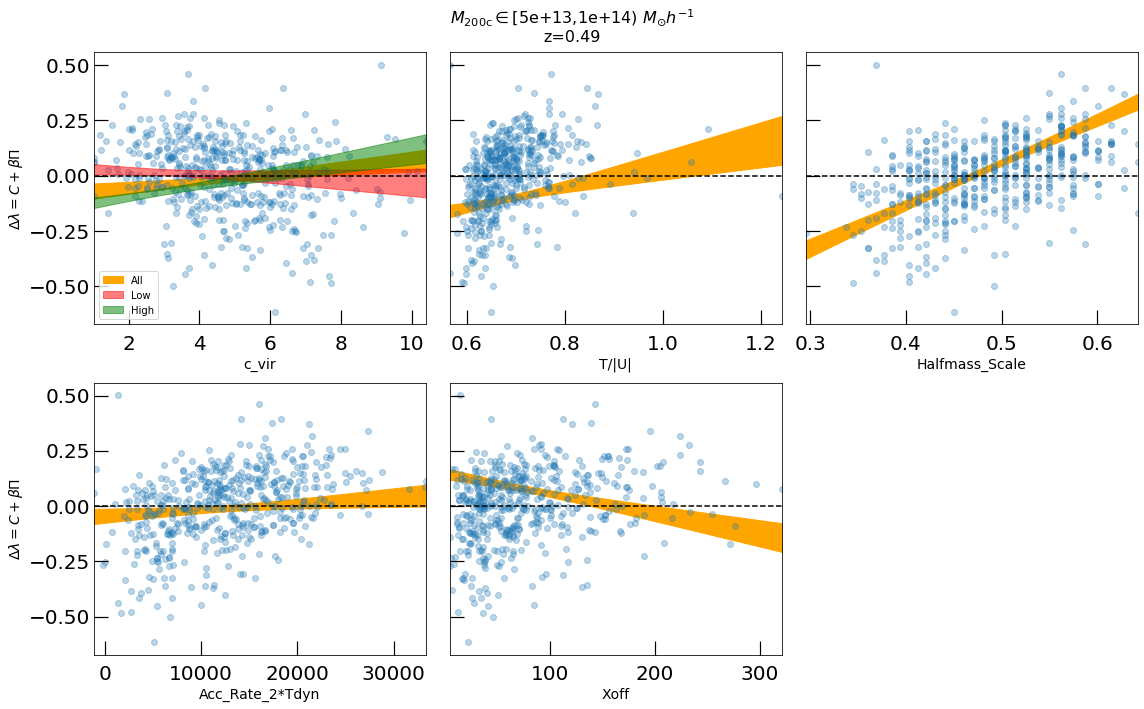

In [278]:
##Plotting
const = 0 #-0.4584

fig, axs = plt.subplots(2,3, figsize=(16,10), tight_layout=True, sharey=True)
axs = axs.reshape(-1)

i=0
for param_name, param_val in X_params_posterior.items():
    x = cur_df[param_name]
    X_range = np.linspace(np.min(cur_df[param_name]),np.max(cur_df[param_name]) )
    const = -0.5*param_val['coef']*(np.max(cur_df[param_name])+np.min(cur_df[param_name])) #So that the mean is 0
    linear_fit = const + param_val['coef']*X_range
    expected_val = const+ param_val['coef']*cur_df[param_name]
    
    # Statistics
    n = len(cur_df)                                          # number of observations
    m = 1                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = dy_kllr                                            # residuals; diff. actual data from predicted values
    chi2 = np.sum((resid / expected_val)**2)                      # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error
    ci = t * s_err * np.sqrt(1/n + (X_range - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        
    
    axs[i].axhline(0,color='black',linestyle='dashed')
    #axs[i].plot(X_range, linear_fit, linewidth=2, color='orange')
    axs[i].fill_between(X_range, linear_fit + ci, linear_fit - ci, color="orange", label='All')
    axs[i].scatter(cur_df[param_name], dy_kllr, alpha=0.3)
    axs[i].set_xlim([np.min(cur_df[param_name]),np.max(cur_df[param_name])])
    
    if np.isin(i,[0,3]):
        axs[i].set_ylabel(r'$\Delta\lambda = C + \beta \Pi $', fontsize=14)
        
    axs[i].set_xlabel(param_name, fontsize=14)
    i += 1
    
axs[5].set_visible(False)
plt.suptitle(r'$M_{\rm 200c} \in $'+'[{:.2g},{:.2g}) '.format(mass_min, mass_max) + r'$M_{\odot}h^{-1}$' + '\n' + 'z={:.2f}'.format(1/scale-1), fontsize=16)



## For concentration only
# Statistics
n = len(cur_df)                                          # number of observations
m = 1                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands
X_range = np.linspace(np.min(cur_df['c_vir']),np.max(cur_df['c_vir']) )

## Low
x = cur_df_low['c_vir']

const = -0.5*c_vir_post['low']*(np.max(cur_df_low['c_vir'])+np.min(cur_df_low['c_vir'])) #So that the mean is 0
linear_fit = const + c_vir_post['low']*X_range
expected_val = const+ c_vir_post['low']*cur_df_low['c_vir']

# Estimates of Error in Data/Model
resid = dy_kllr_low                                            # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / expected_val)**2)                      # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid_low**2) / dof)                    # standard deviation of the error
ci_low = t * s_err * np.sqrt(1/n + (X_range - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
axs[0].fill_between(X_range, linear_fit + ci, linear_fit - ci, color="red", label='Low', alpha=0.5)


## High
x = cur_df_high['c_vir']
const = -0.5*c_vir_post['high']*(np.max(cur_df_high['c_vir'])+np.min(cur_df_high['c_vir'])) #So that the mean is 0
linear_fit = const + c_vir_post['high']*X_range
expected_val = const+ c_vir_post['high']*cur_df_high['c_vir']

# Estimates of Error in Data/Model
resid = dy_kllr_high                                            # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / expected_val)**2)                      # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid_low**2) / dof)                    # standard deviation of the error
ci_low = t * s_err * np.sqrt(1/n + (X_range - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
axs[0].fill_between(X_range, linear_fit + ci, linear_fit - ci, color="green", label='High', alpha=0.5)

axs[0].legend()

## Plot Concentration Only

Create a unified plot for all redshifts. 

In [12]:
c_vir_post = {'all': [-0.0354, 0.0061, 0.0148], 'low': [-0.0471, -0.0175, -0.0066], 'high': [-0.0249, -0.0054, 0.0261]} ##For M in [5e13, 1e14], z={0.00, 0.49, 1.03}.

In [13]:

def mask_df(matched_halo_df, mass_min = 5e13, mass_max = 1e14, scale = 1):
##Mask in mass, redshift bin

    #a_bins = [1, 0.6712, 0.4922]
    mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == scale) 
    cur_df = matched_halo_df[mask]

    ##Split the sample by column
    bin_low = 0
    bin_high = 50
    column_name = 'Acc_Rate_1*Tdyn'
    x_var = cur_df[column_name]
    percentile_x_var = np.vectorize(lambda x: stats.percentileofscore(x_var, x))(x_var)
    mask = (percentile_x_var >= bin_low) & (percentile_x_var < bin_high)
    cur_df_low = cur_df[mask]
    cur_df_high = cur_df[~mask]
    
    return cur_df, cur_df_low, cur_df_high

In [14]:
def richness_residual(cur_df):
    ### Use KLLR
    lm = kllr_model(kernel_type=kernel_type, kernel_width=kernel_width)
    xline, yline, intercept, slopes, scatter, skew, kurt = lm.fit(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), \
                                                                  bins=kllr_nbins, kernel_width=kernel_width, kernel_type=kernel_type, nBootstrap=1) 

    dy_kllr = lm.residuals(np.log10(cur_df.M200c), np.log10(cur_df.Ngal_R200c.values), bins=kllr_nbins, nBootstrap = 1,
                              fast_calc = False, verbose = False, kernel_type=kernel_type, kernel_width=kernel_width)
    
    return dy_kllr

In [15]:
def linear_fit(cur_df, c_vir_post):
    # Statistics
    n = len(cur_df)                                          # number of observations
    m = 1                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.8413, n - m)                              # t-statistic; used for CI and PI bands
    X_range = np.linspace(np.min(cur_df['c_vir']),np.max(cur_df['c_vir']) )
    
    
    ##All
    x = cur_df['c_vir']

    const = -0.5*c_vir_post*(np.max(cur_df['c_vir'])+np.min(cur_df['c_vir'])) #So that the mean is 0
    linear_fit = const + c_vir_post*X_range
    expected_val = const+ c_vir_post*cur_df['c_vir']

    # Estimates of Error in Data/Model
    resid = dy_kllr                                           # residuals; diff. actual data from predicted values
    chi2 = np.sum((resid / expected_val)**2)                      # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error
    ci = t * s_err * np.sqrt(1/n + (X_range - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    return  X_range, linear_fit, ci

In [16]:
m_bins = [[5e13,1e14]];
a_bins = [1, 0.6712, 0.4922]

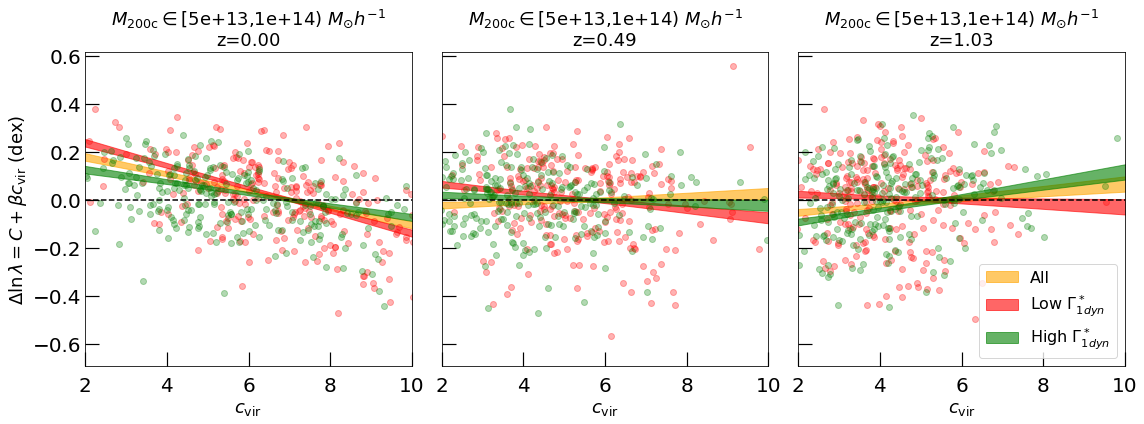

In [21]:
##Plotting
fig, axs = plt.subplots(len(m_bins), len(a_bins), figsize=(16,6), tight_layout=True, sharey=True, sharex=True)
axs = axs.reshape((1,3))
fontsize=18
legendsize=16
alpha = 0.6

for i, m_bin in enumerate(m_bins):
    mass_min = m_bin[0]; mass_max = m_bin[1]
    
    for j, a_cur in enumerate(a_bins):
        z = 1./a_cur-1
        
        ##Finding the residuals for the richness
        cur_df, cur_df_low, cur_df_high = mask_df(matched_halo_df, mass_min = 5e13, mass_max = 1e14, scale = a_cur)
        dy_kllr = richness_residual(cur_df)
        dy_kllr_low = richness_residual(cur_df_low)
        dy_kllr_high = richness_residual(cur_df_high)
        
        ##Finding the linear fit posterior
        beta_cvir_low = c_vir_post['low'][j]
        beta_cvir_high = c_vir_post['high'][j]
        beta_cvir_all = c_vir_post['all'][j]
        
        ##For all
        X_range, Y, ci = linear_fit(cur_df, beta_cvir_all)
        axs[i,j].fill_between(X_range, Y + ci, Y - ci, color="orange", label='All', alpha=alpha)
        
        
        ##For all
        X_range, Y, ci = linear_fit(cur_df, beta_cvir_low)
        axs[i,j].fill_between(X_range, Y + ci, Y - ci, color="red", label='Low $\Gamma^*_{1dyn}$', alpha=alpha)
        axs[i,j].scatter(cur_df_low['c_vir'], dy_kllr_low, alpha=0.3, color='red')
        
        ##For all
        X_range, Y, ci = linear_fit(cur_df, beta_cvir_high)
        axs[i,j].fill_between(X_range, Y + ci, Y - ci, color="green", label='High $\Gamma^*_{1dyn}$', alpha=alpha)
        axs[i,j].scatter(cur_df_high['c_vir'], dy_kllr_high, alpha=0.3, color='green')
        
        
        
        axs[i,j].set_title(r'$M_{\rm 200c} \in $'+'[{:.2g},{:.2g}) '.format(mass_min, mass_max) + \
                            r'$M_{\odot}h^{-1}$' + '\n' + 'z={:.2f}'.format(z), fontsize=fontsize)
        axs[i,j].axhline(0,color='black',linestyle='dashed')
        #axs[i,j].scatter(cur_df['c_vir'], dy_kllr, alpha=0.3)
        axs[i,j].set_xlabel(r'$c_{\rm vir}$', fontsize=fontsize)
        
        
plt.legend(fontsize=legendsize)
axs[0,0].set_ylabel(r'$\Delta \ln\lambda = C + \beta c_{\rm vir} $ (dex)', fontsize=fontsize)
plt.xlim([2,10])
plt.savefig(plotdir + 'richness_vs_cvir_M_5e13_1e14_allz.pdf')